In [1]:
'''
    PyTorch dataset class for COCO-CT-formatted datasets. Note that you could
    use the official PyTorch MS-COCO wrappers:
    https://pytorch.org/vision/master/generated/torchvision.datasets.CocoDetection.html

    We just hack our way through the COCO JSON files here for demonstration
    purposes.

    See also the MS-COCO format on the official Web page:
    https://cocodataset.org/#format-data

    2022 Benjamin Kellenberger
'''

""""
    Turan adjusted this to work on his ROV data. Ben now adjusting to work on reef audio.
    This will make a custom dataset.

"""

### turans old imports
# import os
# import json
# from torch.utils.data import Dataset
# from torchvision.transforms import Compose, Resize, ToTensor
# from PIL import Image
# import csv
# from torchvision.transforms import transforms
# from torchvision import transforms, datasets
################

import os
import torch
import torchaudio
from torchaudio.transforms import MelSpectrogram, TimeMasking, Vol
from torch.utils.data import Dataset

/home/ben/miniconda3/envs/simclr_pytorch_reefs/lib/python3.6/site-packages/torchaudio/backend/utils.py:54: UserWarning: "sox" backend is being deprecated. The default backend will be changed to "sox_io" backend in 0.8.0 and "sox" backend will be removed in 0.9.0. Please migrate to "sox_io" backend. Please refer to https://github.com/pytorch/audio/issues/903 for the detail.
  '"sox" backend is being deprecated. '


In [20]:
#imports by ben
import random

In [10]:
def fade_in_out(audio):
    """
    Fade in/out (FD): gradually increases/decreases the intensity of the audio in the\n
    beginning/end of the audio signal.\n
    The degree of the fade was either linear, logarithmic or exponential (applied\n
    with uniform probability of 1/3). The size of the fade for either side of the\n
    audio signal could at maximum reach half of the audio signal. The size of the\n
    fade was another random parameter picked for each sample.
    """
    assert audio != None, "audio should not be None"
    _fade_shape = ['linear', 'logarithmic', 'exponential']
    _fade_size = [i for i in range(1, int(audio.shape[2]/2))]

    transform = transforms.Fade(fade_in_len=random.choice(_fade_size), fade_out_len=random.choice(_fade_size), fade_shape=random.choice(_fade_shape))
    waveform_fade_in_out = transform(audio)
    return waveform_fade_in_out

In [45]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, audio_dir, sample_rate=16000, n_fft=512, win_length=512, hop_length=64, n_mels=64, time_mask_param=20, fade_duration=1.0):

        self.audio_dir = audio_dir
        self.audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
        
        # Transforms
        self.mel_spectrogram = MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, win_length=win_length, hop_length=hop_length, n_mels=n_mels)
        self.time_masking = TimeMasking(time_mask_param=time_mask_param)
        self.fade_duration = fade_duration

    def __len__(self):
        return len(self.audio_files)
    
    def __fade_function(self, type_, num_samples):
        if type_ == "linear":
            return torch.linspace(0, 1, num_samples)
        elif type_ == "logarithmic":
            return torch.logspace(-4, 0, num_samples)  # You may adjust the base of log as needed
        elif type_ == "exponential":
            return 1 - torch.exp(-torch.linspace(0, 4, num_samples))  # Adjust the rate of exponential as needed
        else:
            raise ValueError("Invalid fade type provided")

    def __getitem__(self, idx):
        audio_file = os.path.join(self.audio_dir, self.audio_files[idx])
        waveform, _ = torchaudio.load(audio_file)
        
        # Fade In/Out with random parameters
        fade_type = random.choice(["linear", "logarithmic", "exponential"])
        max_fade_samples = waveform.shape[-1] // 2
        fade_samples = random.randint(1, max_fade_samples)

        fade_in = self.__fade_function(fade_type, fade_samples).unsqueeze(0)
        fade_out = self.__fade_function(fade_type, fade_samples).flip(dims=[0]).unsqueeze(0)
        
        waveform[:, :fade_samples] *= fade_in
        waveform[:, -fade_samples:] *= fade_out
        
        # Mel Spectrogram
        melspec = self.mel_spectrogram(waveform)
        
        # Time Masking
        melspec = self.time_masking(melspec)

        return melspec

# Usage example:
dataset = MelSpectrogramDataset("/home/ben/data/full_dataset")
print(len(dataset))
melspec_sample = dataset[0]
#dataset[0]
#print(melspec_sample.shape)

dataset[0].shape


79066


torch.Size([1, 64, 481])

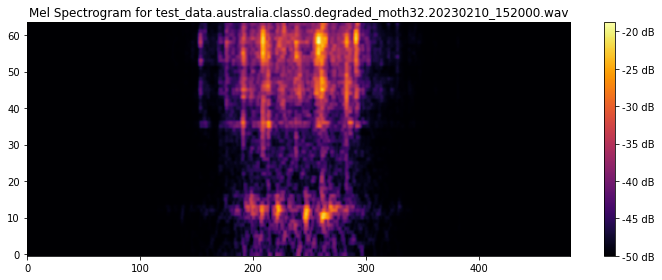

In [46]:
import matplotlib.pyplot as plt
import numpy as np

def plot_melspec(dataset, idx):
    melspec = dataset[idx].squeeze().numpy()
    melspec_db = 10 * np.log10(melspec + 1e-5)  # Convert to dB scale for better visualization
    plt.figure(figsize=(10, 4))
    plt.imshow(melspec_db, origin="lower", aspect="auto", cmap="inferno")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel Spectrogram for {dataset.audio_files[idx]}")
    plt.tight_layout()
    plt.show()

# Usage:
dataset = MelSpectrogramDataset("/home/ben/data/full_dataset")
plot_melspec(dataset, 10)

In [16]:
class MelSpectrogramDataset(Dataset):
    def __init__(self, audio_dir, sample_rate=16000, n_fft=400, win_length=400, hop_length=200, n_mels=128, time_mask_param=20, fade_duration=1.0):
        self.audio_dir = audio_dir
        self.audio_files = [f for f in os.listdir(audio_dir) if f.endswith('.wav')]
        
        # Transforms
        self.mel_spectrogram = MelSpectrogram(sample_rate=sample_rate, n_fft=n_fft, win_length=win_length, hop_length=hop_length, n_mels=n_mels)
        self.time_masking = TimeMasking(time_mask_param=time_mask_param)
        self.fade_duration = fade_duration

    def __len__(self):
        return len(self.audio_files)

    def __getitem__(self, idx):
        audio_file = os.path.join(self.audio_dir, self.audio_files[idx])
        waveform, _ = torchaudio.load(audio_file)
        
        # Fade In/Out
        fade_samples = int(self.fade_duration * waveform.shape[-1])
        fade_in = torch.linspace(0, 1, fade_samples).unsqueeze(0)
        fade_out = torch.linspace(1, 0, fade_samples).unsqueeze(0)
        waveform[:, :fade_samples] *= fade_in
        waveform[:, -fade_samples:] *= fade_out

        # Mel Spectrogram
        melspec = self.mel_spectrogram(waveform)
        
        # Time Masking
        melspec = self.time_masking(melspec)

        return melspec

# Usage example:
dataset = MelSpectrogramDataset("/home/ben/data/full_dataset")
print(len(dataset))
melspec_sample = dataset[0]
#dataset[0]
#print(melspec_sample.shape)


79066


/home/ben/miniconda3/envs/simclr_pytorch_reefs/lib/python3.6/site-packages/torchaudio/functional.py:318: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  "At least one mel filterbank has all zero values. "


In [30]:
dataset[0].shape

torch.Size([1, 224, 433])

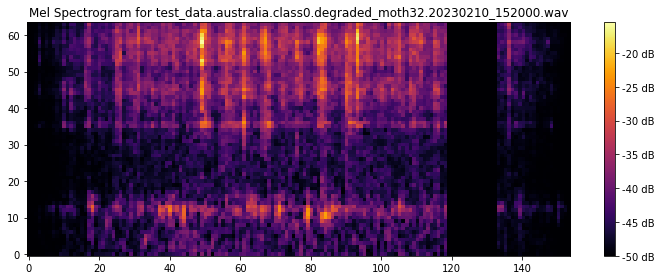

In [26]:
import matplotlib.pyplot as plt
import numpy as np

def plot_melspec(dataset, idx):
    melspec = dataset[idx].squeeze().numpy()
    melspec_db = 10 * np.log10(melspec + 1e-5)  # Convert to dB scale for better visualization
    plt.figure(figsize=(10, 4))
    plt.imshow(melspec_db, origin="lower", aspect="auto", cmap="inferno")
    plt.colorbar(format="%+2.0f dB")
    plt.title(f"Mel Spectrogram for {dataset.audio_files[idx]}")
    plt.tight_layout()
    plt.show()

# Usage:
dataset = MelSpectrogramDataset("/home/ben/data/full_dataset")
plot_melspec(dataset, 10)